In [20]:
from importlib import reload
from load_cluster_data import load_cluster_data
from pca_kmeans_init import pca_kmeans_init
from betabinomo_mix_singlecells import *
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)
import torch
import sklearn.manifold 
import plotnine as p9
import time

## Settings

In [2]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MAKE_PCA_TSNE = True

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 15 # should also be an argument that gets fed in

cuda


## Load data

In [ ]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])
N = coo_cluster_sparse.shape[0]
J = coo_cluster_sparse.shape[1]

cell_index_tensor, junc_index_tensor, my_data = betabinomo_mix_singlecells.make_torch_data(final_data, **float_type)

In [10]:
K = 15 # should also be an argument that gets fed in

cell_pcs, pc_sd, init_labels = pca_kmeans_init(final_data, junc_index_tensor, cell_index_tensor, K, float_type)


In [24]:
    
num_trials = 10 # should also be an argument that gets fed in
num_iters = 50 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
reload(betabinomo_mix_singlecells)
start_time = time.time()
results = [ betabinomo_mix_singlecells.calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]
print(time.time() - start_time)

Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23766616.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23764992.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23766648.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23737678.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23767028.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23738384.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23749258.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23741334.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23743452.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO conver

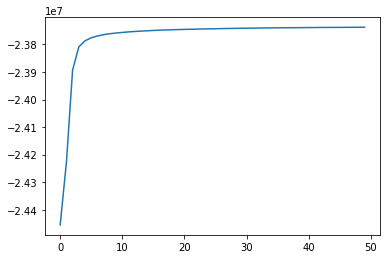

In [25]:

best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
    # run coordinate ascent VI
#ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(J, K, N, my_data, init_labels = None, num_iterations = num_iters)
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()
    

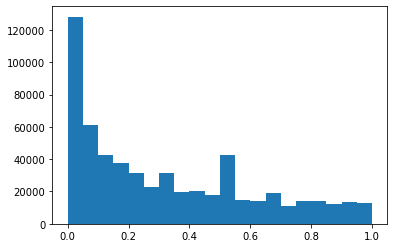

In [28]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)    
plt.hist(juncs_probs.cpu().numpy().flatten(), 20); plt.show()

In [29]:
theta_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
print(theta_f_plot_summ)

                   0             1         2         3         4         5  \
cell_id                                                                      
B           0.092715  1.670985e-02  0.160622  0.067583  0.021740  0.087911   
CD14Mono    0.108756  1.152848e-02  0.165727  0.074690  0.014173  0.082844   
CD8T        0.108022  8.154589e-03  0.181587  0.067941  0.015751  0.093684   
DC          0.105282  8.233580e-03  0.188199  0.058767  0.010975  0.065519   
FCGR3A      0.107413  1.190037e-02  0.154626  0.081110  0.023076  0.088654   
IGHA        0.098831  6.036226e-03  0.235888  0.058324  0.011788  0.065309   
MemoryCD4T  0.093309  1.442011e-02  0.166126  0.063541  0.020345  0.091406   
NK          0.099624  1.502037e-02  0.162388  0.067333  0.019872  0.090650   
NaiveCD4T   0.103668  1.136746e-02  0.172361  0.065655  0.015652  0.090095   
ZNF385D     0.018874  4.212681e-07  0.447074  0.028627  0.000003  0.065009   

                   6             7         8         9        1

How much each cluster is used

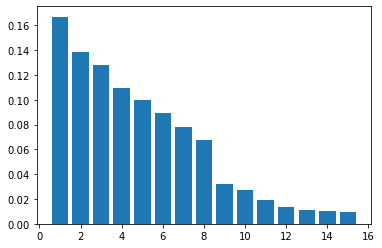

In [30]:
theta = GAMMA_f / GAMMA_f.sum()
theta = theta.cpu().numpy()
theta_sorted = np.sort(theta)
plt.bar(np.arange(K)+1,theta_sorted[::-1]); plt.show()


We're basically get hard assignmed :/ This means it doesn't make much sense to do an embedding/UMAP etc

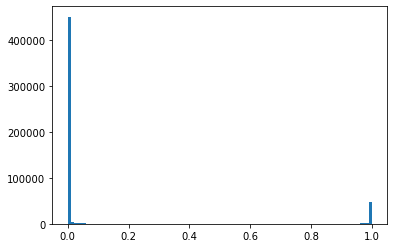

In [34]:
to_keep = theta > 0.04

x = PHI_f.cpu().numpy()
x = x[:,to_keep]
#x -= x.mean(1,keepdims=True)
#x /= x.std(1,keepdims=True)
_ = plt.hist(x.flatten(),100)

<Figure size 720x576 with 0 Axes>

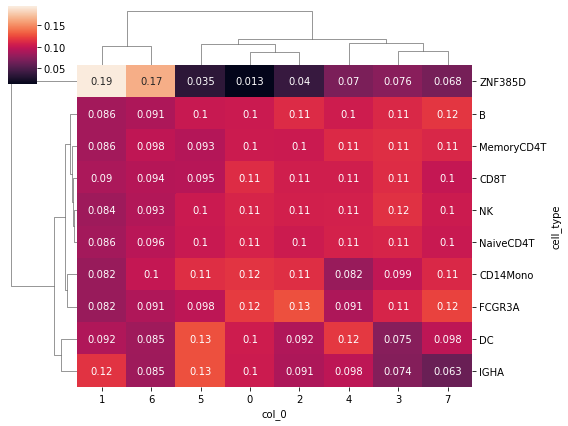

In [35]:
ct = pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )
ct_np = ct.to_numpy()

ct_np = ct_np / ct_np.sum(1, keepdims=True) # normalize cell-type counts
ct_np = ct_np / ct_np.sum(0, keepdims=True)

ct.iloc[:,:] = ct_np

ax = plt.figure(figsize=[10,8])
sns.clustermap(ct, dendrogram_ratio=0.15, vmin = None, figsize=(8,6), annot = True)
#plt.savefig("Cluster_heatmap.pdf")


In [4]:
final_data[ ["cell_id_index",] ]

ind = (final_data['cell_id_index'].values, final_data['junction_id_index'].values)
y_all = sp.coo_matrix( (final_data.junc_count.values, ind ))
n_all = sp.coo_matrix( (final_data.cluster_count.values, ind ))
nz_all = sp.coo_matrix( (np.ones(M), ind ))

y_csr = y_all.tocsr()
n_csr = n_all.tocsr()
nz_csr = nz_all.tocsr()


summarized_data = pd.read_hdf(input_file, 'df')
cluster_data = summarized_data[["cell_id_index","Cluster","Cluster_Counts"]].drop_duplicates()
#summarized_data['cell_id_index'] = summarized_data.groupby('cell_id').ngroup()
#summarized_data['junction_id_index'] = summarized_data.groupby('junction_id').ngroup()


cluster_counts = sp.coo_matrix( (cluster_data.Cluster_Counts.values, (cluster_data.cell_id_index.values, cluster_data.Cluster.values) ))
to_keep = sparse_sum(cluster_counts,0) > 0
cluster_counts = cluster_counts.tocsr()[:,to_keep]
cluster_counts = cluster_counts.tocoo()
cluster_counts.data = np.ones_like(cluster_counts.data)
cell_clusters = sparse_sum(cluster_counts,1) 
plt.xlabel("Percent clusters observed per cell")


junc_counts = final_data[final_data.junc_count > 0]
ind = (junc_counts['cell_id_index'].values, junc_counts['junction_id_index'].values)
junc_presence = sp.coo_matrix( (np.ones(junc_counts.shape[0]), ind ))

plt.hist(100 * cell_clusters / 11585, 30, alpha=0.5, label = "Clusters") 
plt.hist(100 * sparse_sum(junc_presence,1) / 38802, 30, alpha=0.5, label = "Junctions")
plt.xlabel("Percent observed (>0 UMI) per cell", fontsize=14)
plt.legend(fontsize=12)
plt.savefig("percent_obs.pdf")


## PCA initialization

In [5]:
cell_pcs, pc_sd, init_labels = pca_kmeans_init(final_data, my_data.junc_index, my_data.cell_index, K, float_type)

Look at the PCs

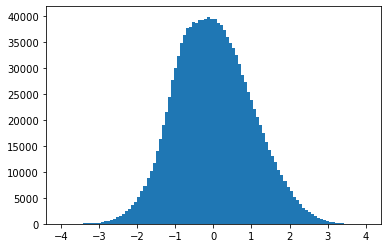

In [6]:
pcs_scaled = cell_pcs.copy()
pcs_scaled -= pcs_scaled.mean(1,keepdims=True)
pcs_scaled /= pcs_scaled.std(1,keepdims=True)
_ = plt.hist(pcs_scaled.flatten(),100)

tSNE on scaled PCs (takes 5-10min)

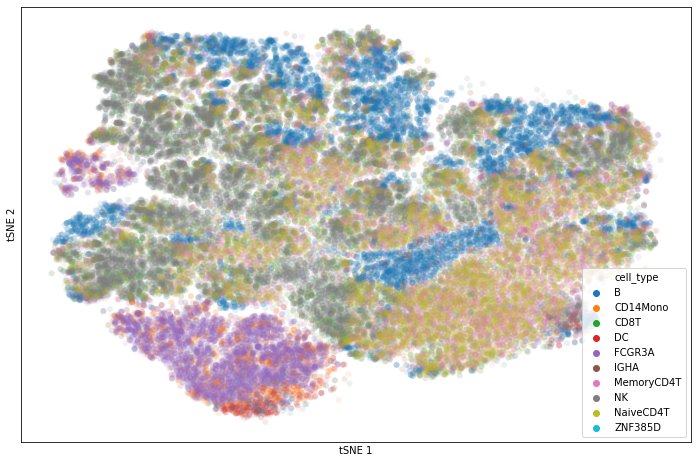

In [7]:
if MAKE_PCA_TSNE: 
    pcs_sd_scaled = cell_pcs * pc_sd

    PCs_embedded = sklearn.manifold.TSNE(
        n_components=2, 
        learning_rate='auto',
        init='random', 
        perplexity=30).fit_transform(pcs_sd_scaled)

    PC_embed_df = pd.DataFrame(PCs_embedded, columns = ["x","y"])
    PC_embed_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
    #p9.ggplot(X_embed_df, p9.aes(x = "x", y="y", color = "cell_type")) + p9.geom_point()

    #plt.figure(figsize=[8,6]) # for pdf
    plt.figure(figsize=[12,8])
    sns.scatterplot(x = "x",y = "y", hue="cell_type", data= PC_embed_df, edgecolor = 'none', alpha = 0.1)
    plt.xlabel("tSNE 1")
    plt.ylabel("tSNE 2")
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.savefig("pca_eig_scaled.pdf")

Label by K-means clustering

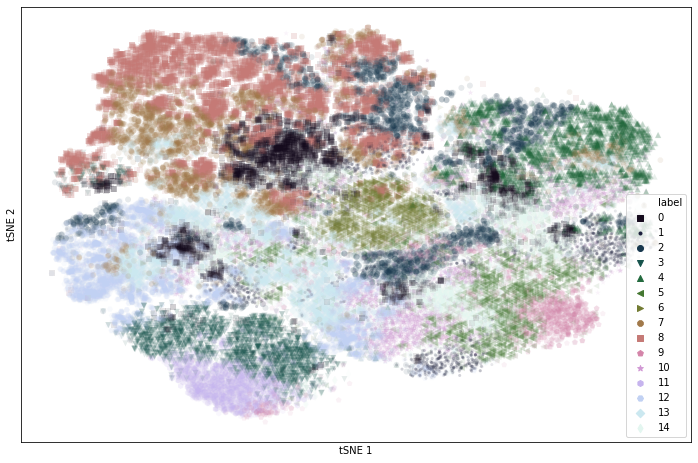

In [27]:
markers = [',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    
if MAKE_PCA_TSNE: 
    PC_embed_df["label"] = init_labels

    plt.figure(figsize=[12,8])
    sns.scatterplot(
        x = "x",y = "y", hue="label", style="label", data= PC_embed_df, 
        edgecolor = 'none', alpha = 0.1, markers = markers, palette=sns.color_palette("cubehelix",15))
    plt.xlabel("tSNE 1")
    plt.ylabel("tSNE 2")
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

## Fit LDA

15
Initialize VI params
Got the initial ELBO
ELBO converged, CAVI iteration #  300  complete
                   0         1         2         3         4         5  \
cell_id                                                                  
B           0.066124  0.064134  0.093842  0.053866  0.065762  0.064567   
CD14Mono    0.053637  0.060591  0.052607  0.108792  0.048901  0.065735   
CD8T        0.062528  0.069271  0.054806  0.051588  0.060487  0.071602   
DC          0.049071  0.057497  0.049712  0.071502  0.043978  0.066119   
FCGR3A      0.057504  0.058910  0.053576  0.122716  0.053647  0.058486   
IGHA        0.041277  0.050069  0.044398  0.047785  0.040270  0.073053   
MemoryCD4T  0.061762  0.071289  0.057464  0.050659  0.063058  0.082164   
NK          0.062720  0.062243  0.054033  0.054950  0.059614  0.063932   
NaiveCD4T   0.062040  0.073095  0.055031  0.050038  0.060106  0.082412   
ZNF385D     0.028395  0.052551  0.048349  0.061951  0.026345  0.042710   

                  

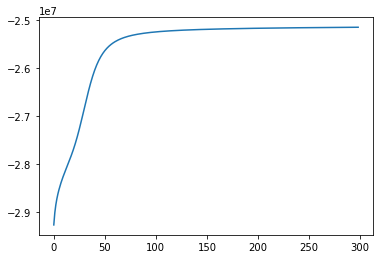

In [9]:
num_trials = 1 # can't currently run more than 1 or overflow GPU memory :( 
num_iters = 300 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
for t in range(num_trials):

    # run coordinate ascent VI
    print(K)

    ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(K, my_data, float_type, hypers = hypers, init_labels = init_labels, num_iterations = num_iters)
    elbos_all = np.array(elbos_all)
    juncs_probs = ALPHA_f / (ALPHA_f+PI_f)
    #theta_f = distributions.Dirichlet(GAMMA_f).sample()
    # z_f = distributions.Categorical(PHI_f).sample() # this would be pretty big! 
    #make theta_f a dataframe 
    theta_f = GAMMA_f / GAMMA_f.sum(1,keepdim=True)
    theta_f_plot = pd.DataFrame(theta_f.cpu())
    theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
    theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
    print(theta_f_plot_summ)
    
    # save the learned variational parameters
    #np.savez('variational_params.npz', ALPHA_f=ALPHA_f, PI_f=PI_f, GAMMA_f=GAMMA_f, PHI_f=PHI_f, juncs_probs=juncs_probs, theta_f=theta_f, z_f=z_f)


    # plot ELBOs. With K=15 PCA-Kmeans init: -25159712.0
    # With random initialization: -25259360.0 (so somewhat worse)
    plt.plot(elbos_all[2:]); plt.show()

In [10]:
elbos_all[-1]

-25155528.0

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cell_type,,,,,,,,,,,,,,,
B,762,715,2111,391,806,880,490,553,942,1404,925,553,811,713,1222
CD14Mono,69,87,63,428,47,135,34,81,68,211,102,535,119,101,174
CD8T,353,511,235,182,337,605,319,592,312,633,686,300,662,711,694
DC,17,34,24,66,15,53,15,22,12,326,70,211,38,48,142
FCGR3A,192,173,174,1395,155,210,85,169,184,373,252,1339,304,236,387
IGHA,4,8,7,9,9,21,8,10,3,308,19,8,13,28,42
MemoryCD4T,520,877,464,235,624,1448,514,614,478,1169,1363,418,760,748,1594
NK,729,736,475,423,699,920,645,1918,704,1238,1102,566,1304,2244,1270
NaiveCD4T,421,693,295,165,373,1102,365,453,328,823,1103,310,538,581,1153


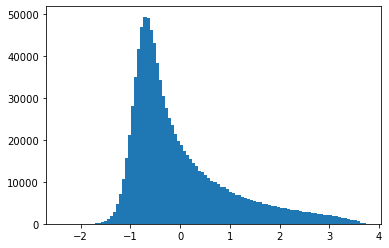

In [11]:
x = theta_f.cpu().numpy()
x -= x.mean(1,keepdims=True)
x /= x.std(1,keepdims=True)
plt.hist(x.flatten(),100)
pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )

In [12]:
X_embedded = sklearn.manifold.TSNE(
    n_components=2, 
    learning_rate='auto',
    init='random', 
    perplexity=100).fit_transform(x)
X_embed_df = pd.DataFrame(X_embedded, columns = ["x","y"])
X_embed_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()

[]

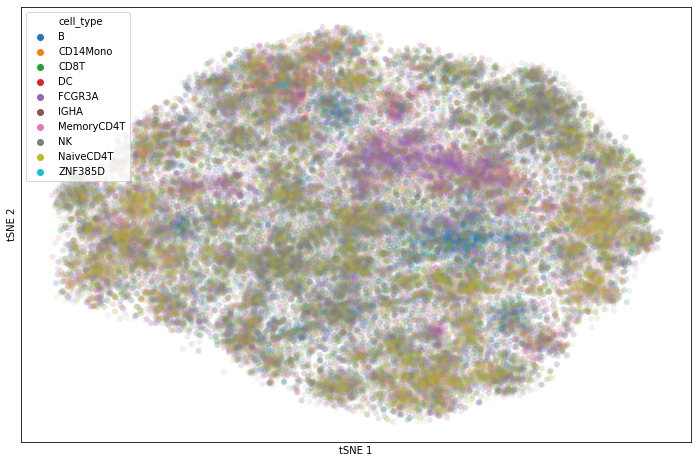

In [13]:
plt.figure(figsize=[12,8])
sns.scatterplot(x = "x",y = "y", hue="cell_type", data= X_embed_df, edgecolor = 'none', alpha = 0.1)
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig("pca_eig_scaled.pdf")
